In [1]:
import math
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from gc_aux import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [2]:
#define the model

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.rbf_kernel_1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.rbf_kernel_2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.rbf_kernel_1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.rbf_kernel_2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.covar_module = gpytorch.kernels.AdditiveKernel(self.rbf_kernel_1, self.rbf_kernel_2)

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)

In [3]:
# load the data
df_raw = pd.read_excel('data/LFVL_v2.xlsx')
df_val_test_raw = pd.read_excel('data/val_test.xlsx')
#splitting the train set and val/test set
duplicates = df_raw['SMILES'].isin(df_val_test_raw['SMILES'])
df_train = df_raw[~duplicates]
df_val_test = df_raw[duplicates]

In [4]:
df_train_raw = df_train
df_val_test_raw = df_val_test

In [5]:
df_raw = pd.read_excel('data/new_excels/Pc.xlsx')

In [6]:
df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=90)

prop_tag = 'Pc'

In [7]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [8]:
# extract target values
df_target_all = df_raw['Const_Value']
# extract all groups
df_grp_all = df_raw.loc[:,'CH3':]
df_grp_all = df_grp_all.iloc[:,:220+130+74]

G = df_grp_all.iloc[:,:220+130+74].to_numpy()
G_fog = G[:,:220]
G_sog = G[:,220:220+130]
G_tog = G[:,220+130:220+130+74]
# extract y
y = df_target_all.to_numpy()

In [9]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O']
len_move = len(smiles_list)

df_to_move = df_val_test_80[df_val_test_80['SMILES'].isin(smiles_list)]
row_to_move = df_train_80.iloc[[-len_move]]

df_train_80 = df_train_80.drop(row_to_move.index)
df_train_80 = pd.concat([df_train_80, df_to_move], ignore_index=True)

df_val_test_80 = df_val_test_80[~df_val_test_80['SMILES'].isin(smiles_list)]
df_val_test_80 = pd.concat([df_val_test_80, row_to_move], ignore_index=True)

df_train_80.to_csv('data/df_train_95.csv', index=False)

In [10]:
#preparing the train set
df_train = df_train_80

const_value_index = df_train.columns.get_loc("Const_Value")
df_train.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_train.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_train.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

df_target = df_train['Const_Value']
df_grp = df_train.loc[:,'CH3':]
df_grp = df_grp.iloc[:,:220+130+74]

# G_train = df_grp.to_numpy()
fog_train = df_grp.to_numpy()[:,:220]
y_train = df_target.to_numpy()

In [11]:
#preparing the val/test set
df_val_test = df_val_test_80

df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42)

df_val.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_val.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_val.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

df_test.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_test.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_test.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

#preparing val set
df_val_grp = df_val.loc[:,'CH3':]
df_val_grp = df_val_grp.iloc[:,:220+130+74]
fog_val = df_val_grp.to_numpy()[:,:220]
y_val = df_val['Const_Value'].to_numpy()

#preparing test set
df_test_grp = df_test.loc[:,'CH3':]
df_test_grp = df_test_grp.iloc[:,:220+130+74]
fog_test = df_test_grp.to_numpy()[:,:220]
y_test = df_test['Const_Value'].to_numpy()

first-order groups

In [12]:
#define the scaler
scaler_fog = StandardScaler()
#fit the scaler
scaler_fog.fit(y.reshape(-1, 1))
#apply scaler
ys_train_fog = scaler_fog.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val_fog = scaler_fog.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test_fog = scaler_fog.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

#preparing torch tensor
fog_train_to = torch.from_numpy(fog_train).float()
y_train_fog_to = torch.from_numpy(ys_train_fog).float()
fog_val_to = torch.from_numpy(fog_val).float()
y_val_fog_to = torch.from_numpy(ys_val_fog).float()
fog_test_to = torch.from_numpy(fog_test).float()
y_test_fog_to = torch.from_numpy(ys_test_fog).float()
G_fog_to = torch.from_numpy(G_fog).float()

In [13]:
likelihood_fog = gpytorch.likelihoods.GaussianLikelihood()
gpr_fog = GPModel(fog_train_to, y_train_fog_to, likelihood_fog)

gpr_fog.train()
likelihood_fog.train()

optimizer_fog = torch.optim.Adam(gpr_fog.parameters(), lr=1e-3, weight_decay=0.1)
scheduler_fog = ReduceLROnPlateau(optimizer_fog, 'min', factor=0.1, patience=190, verbose=True)

mll_fog = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_fog, gpr_fog)

In [14]:
training_iter = 50000
train_losses = []
val_losses = []

best_loss = float('inf')
cnt = 0
patience = 500

for i in range(training_iter):
    gpr_fog.train()
    likelihood_fog.train()

    optimizer_fog.zero_grad()
    output = gpr_fog(fog_train_to)
    loss = -mll_fog(output, y_train_fog_to)
    loss.backward()
    optimizer_fog.step()
    train_losses.append(loss.item())

    gpr_fog.eval()
    likelihood_fog.eval()
    with torch.no_grad():
        val_output = gpr_fog(fog_val_to)
        val_loss = -mll_fog(val_output, y_val_fog_to)
        val_loss_mae =  mean_absolute_error(y_val_fog_to.numpy(), val_output.mean.numpy())
        #early stopping
        if val_loss_mae < best_loss:
            best_loss = val_loss_mae
            cnt = 0
            torch.save(gpr_fog.state_dict(), 'gpr_fog'+ prop_tag+'.pth')
        else:
            cnt += 1
            if cnt >= patience:
                print(f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]'+"Early stopping")
                break
                
    val_losses.append(val_loss)
    scheduler_fog.step(val_loss)
    
    msg = (f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]' +
       f'train loss:{loss.item():.5f}' + 
       f'validation loss:{val_loss.item():.5f}')   
    if i%100 == 0:
        print(msg)

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2198.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


[    0/50000]train loss:1.43504validation loss:1.21047
[  100/50000]train loss:1.39245validation loss:1.16052
[  200/50000]train loss:1.36130validation loss:1.11280
[  300/50000]train loss:1.33216validation loss:1.06664
[  400/50000]train loss:1.29656validation loss:1.02303
[  500/50000]train loss:1.26123validation loss:0.98150
[  600/50000]train loss:1.22655validation loss:0.94291
[  700/50000]train loss:1.21149validation loss:0.90589
[  800/50000]train loss:1.18421validation loss:0.87056
[  900/50000]train loss:1.15636validation loss:0.83638
[ 1000/50000]train loss:1.12470validation loss:0.80431
[ 1100/50000]train loss:1.10720validation loss:0.77273
[ 1200/50000]train loss:1.06813validation loss:0.74256
[ 1300/50000]train loss:1.06232validation loss:0.71521
[ 1400/50000]train loss:1.04341validation loss:0.68775
[ 1500/50000]train loss:1.02279validation loss:0.66257
[ 1600/50000]train loss:1.00195validation loss:0.63906
[ 1700/50000]train loss:0.98360validation loss:0.61771
[ 1800/500

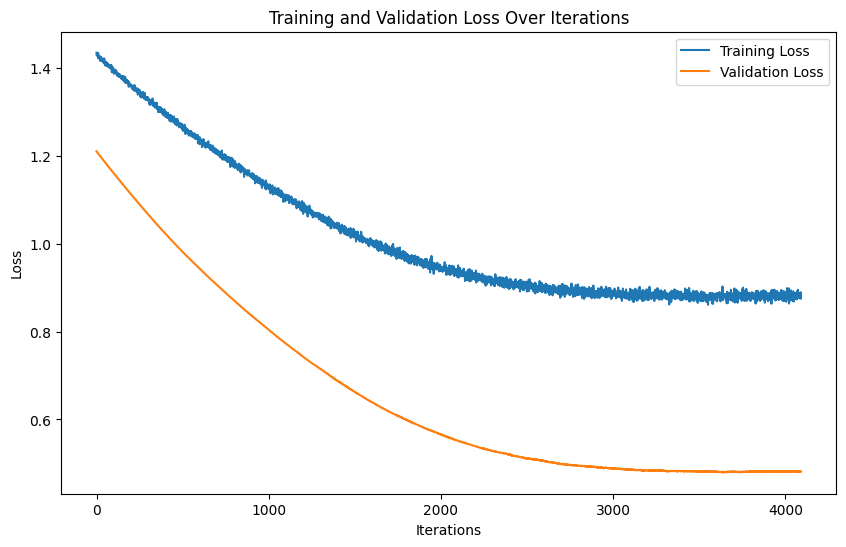

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.show()

In [16]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ys_pred_test_fog = likelihood_fog(gpr_fog(fog_test_to))
    ys_pred_train_fog = likelihood_fog(gpr_fog(fog_train_to))
    ys_pred_val_fog = likelihood_fog(gpr_fog(fog_val_to))
    ys_pred_fog = likelihood_fog(gpr_fog(G_fog_to))

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [17]:
y_pred_test_fog = scaler_fog.inverse_transform(ys_pred_test_fog.mean.detach().numpy().reshape(-1, 1)).reshape(y_test.size,)
y_pred_train_fog = scaler_fog.inverse_transform(ys_pred_train_fog.mean.detach().numpy().reshape(-1, 1)).reshape(y_train.size,)
y_pred_val_fog = scaler_fog.inverse_transform(ys_pred_val_fog.mean.detach().numpy().reshape(-1, 1)).reshape(y_val.size,)
y_pred_fog = scaler_fog.inverse_transform(ys_pred_fog.mean.detach().numpy().reshape(-1, 1)).reshape(y.size,)

y_pred_test_vars_fog = scaler_fog.inverse_transform(ys_pred_test_fog.variance.detach().numpy().reshape(-1, 1)).reshape(y_test.size,)

mae_fog = mean_absolute_error(y_test, y_pred_test_fog)
r2_fog = r2_score(y_test, y_pred_test_fog)

print("MAE on test set:", mae_fog)
print("R2 on test set:", r2_fog)

MAE on test set: 2.563241934517839
R2 on test set: 0.8695211839128794


In [19]:
#results on train set with only first-order groups
print("MAE on train set:", mean_absolute_error(y_train, y_pred_train_fog ))
print("R2 on train set:", r2_score(y_train, y_pred_train_fog ))

MAE on train set: 0.890529102117028
R2 on train set: 0.9920550750866555


In [20]:
#results on train set with only first-order groups
print("MAE on train set:", mean_absolute_error(y_val, y_pred_val_fog))
print("R2 on train set:", r2_score(y_val, y_pred_val_fog))

MAE on train set: 2.3455132119998434
R2 on train set: 0.862041187665832


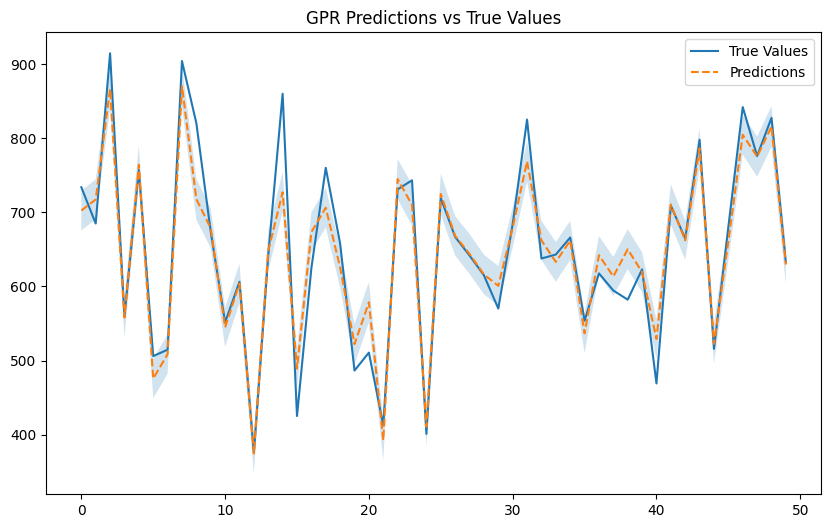

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_test_fog, label='Predictions', linestyle='--')
plt.fill_between(np.arange(len(y_test)), 
                 y_pred_test_fog - np.sqrt(y_pred_test_vars_fog), 
                 y_pred_test_fog + np.sqrt(y_pred_test_vars_fog), 
                 alpha=0.2)
plt.legend()
plt.title("GPR Predictions vs True Values")
plt.show()

second-order groups

In [21]:
df_train['Pred_Fog'] = y_pred_train_fog
df_val['Pred_Fog'] = y_pred_val_fog
df_test['Pred_Fog'] = y_pred_test_fog

In [22]:
df_train_sog = df_train.loc[(df_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_train_grp = df_train_sog.loc[:,'CH3':]
sog_train = sog_train_grp.iloc[:,220:220+130].to_numpy()
y_train_sog = df_train_sog['Const_Value'].to_numpy()

df_val_sog = df_val.loc[(df_val_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_val_grp = df_val_sog.loc[:,'CH3':]
sog_val = sog_val_grp.iloc[:,220:220+130].to_numpy()
y_val_sog = df_val_sog['Const_Value'].to_numpy()

df_test_sog = df_test.loc[(df_test_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_test_grp = df_test_sog.loc[:,'CH3':]
sog_test = sog_test_grp.iloc[:,220:220+130].to_numpy()
y_test_sog = df_test_sog['Const_Value'].to_numpy()

In [23]:
diff_train_sog = y_train_sog - df_train_sog['Pred_Fog'].to_numpy()
diff_val_sog =  y_val_sog - df_val_sog['Pred_Fog'].to_numpy()
diff_test_sog =  y_test_sog - df_test_sog['Pred_Fog'].to_numpy()
diff_sog = y - y_pred_fog

#if the difference between the true value and predicted value from first order groups are not that huge, the scaler is not
#applied here

#define the scaler
scaler_sog = StandardScaler()
#fit the scaler
scaler_sog.fit(diff_sog.reshape(-1, 1))
#apply scaler
ys_train_sog = scaler_sog.transform(diff_train_sog.reshape(-1, 1)).reshape(diff_train_sog.size,)
ys_val_sog = scaler_sog.transform(diff_val_sog.reshape(-1, 1)).reshape(diff_val_sog.size,)
ys_test_sog = scaler_sog.transform(diff_test_sog.reshape(-1, 1)).reshape(diff_test_sog.size,)

sog_train_to = torch.from_numpy(sog_train).float()
y_train_sog_to = torch.from_numpy(ys_train_sog).float()
sog_val_to = torch.from_numpy(sog_val).float()
y_val_sog_to = torch.from_numpy(ys_val_sog).float()
sog_test_to = torch.from_numpy(sog_test).float()
G_sog_to = torch.from_numpy(G_sog).float()

In [24]:
likelihood_sog = gpytorch.likelihoods.GaussianLikelihood()
gpr_sog = GPModel(sog_train_to, y_train_sog_to, likelihood_sog)

optimizer_sog = torch.optim.Adam(gpr_sog.parameters(), lr=1e-3, weight_decay=0.1)
scheduler_sog = ReduceLROnPlateau(optimizer_sog, 'min', factor=0.1, patience=100, verbose=True)

mll_sog = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_sog, gpr_sog)

In [25]:
training_iter = 50000
train_losses = []
val_losses = []

best_loss = float('inf')
cnt = 0
patience = 200

for i in range(training_iter):
    gpr_sog.train()
    likelihood_sog.train()

    optimizer_sog.zero_grad()
    output = gpr_sog(sog_train_to)
    loss = -mll_sog(output, y_train_sog_to)
    loss.backward()
    optimizer_sog.step()
    train_losses.append(loss.item())

    gpr_sog.eval()
    likelihood_sog.eval()
    with torch.no_grad():
        val_output = gpr_sog(sog_val_to)
        val_loss = -mll_sog(val_output, y_val_sog_to)
        val_loss_mae =  mean_absolute_error(y_val_sog_to.numpy(), val_output.mean.numpy())
        #early stopping
        if val_loss_mae < best_loss:
            best_loss = val_loss_mae
            cnt = 0
            torch.save(gpr_sog.state_dict(), 'best_model_gpr_sog.pth')
        else:
            cnt += 1
            if cnt >= patience:
                print(f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]'+"Early stopping")
                break
                
    val_losses.append(val_loss)
    scheduler_sog.step(val_loss)
    
    msg = (f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]' +
       f'train loss:{loss.item():.5f}' + 
       f'validation loss:{val_loss.item():.5f}')   
    if i%100 == 0:
        print(msg)

[    0/50000]train loss:1.20791validation loss:2.10369
[  100/50000]train loss:1.18565validation loss:2.16398
Epoch 00102: reducing learning rate of group 0 to 1.0000e-04.
[  200/50000]train loss:1.18818validation loss:2.16942
Epoch 00203: reducing learning rate of group 0 to 1.0000e-05.
[  229/50000]Early stopping


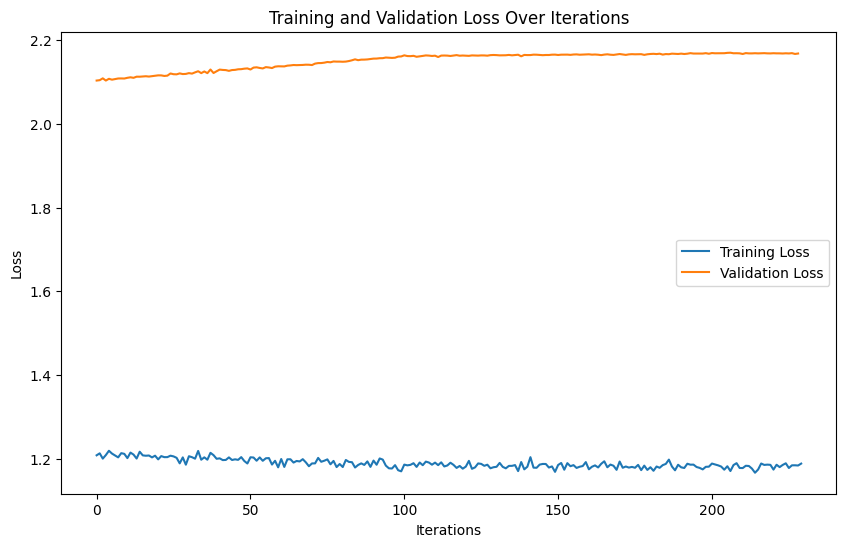

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.show()

In [27]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ys_pred_test_sog = likelihood_sog(gpr_sog(sog_test_to))
    ys_pred_train_sog = likelihood_sog(gpr_sog(sog_train_to))
    ys_pred_val_sog = likelihood_sog(gpr_sog(sog_val_to))
    ys_pred_sog = likelihood_sog(gpr_sog(G_sog_to))

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [28]:
# diff_pred_test_sog = ys_pred_test_sog.mean.detach().numpy()
# diff_pred_train_sog = ys_pred_train_sog.mean.detach().numpy()
# diff_pred_val_sog = ys_pred_val_sog.mean.detach().numpy()
# diff_pred_sog = ys_pred_sog.mean.detach().numpy()

# diff_pred_test_vars_sog = ys_pred_test_sog.variance.detach().numpy()

diff_pred_test_sog = scaler_sog.inverse_transform(ys_pred_test_sog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_test_sog.size,)
diff_pred_train_sog = scaler_sog.inverse_transform(ys_pred_train_sog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_train_sog.size,)
diff_pred_val_sog = scaler_sog.inverse_transform(ys_pred_val_sog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_val_sog.size,)
diff_pred_sog = scaler_sog.inverse_transform(ys_pred_sog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_sog.size,)

y_pred_test_vars_sog = scaler_sog.inverse_transform(ys_pred_test_sog.variance.detach().numpy().reshape(-1, 1)).reshape(diff_test_sog.size,)

mae_sog = mean_absolute_error(y_test_sog, df_test_sog['Pred_Fog'].to_numpy()+diff_pred_test_sog)
r2_sog = r2_score(y_test_sog, df_test_sog['Pred_Fog'].to_numpy()+diff_pred_test_sog)

print("MAE on test set:", mae_sog)
print("R2 on test set:", r2_sog)

#there are only two values in the test set in the second step, so should not evaluate it here

MAE on test set: 2.4329392963178216
R2 on test set: 0.8546965017090533


In [29]:
#results on train set with only second-order groups
print("MAE on train set:", mean_absolute_error(y_train_sog, df_train_sog['Pred_Fog'].to_numpy()+diff_pred_train_sog))
print("R2 on train set:", r2_score(y_train_sog, df_train_sog['Pred_Fog'].to_numpy()+diff_pred_train_sog))

MAE on train set: 0.6469160305835002
R2 on train set: 0.9972617148306038


third-order groups

In [30]:
df_train_sog['Pred_Sog'] = diff_pred_train_sog
df_val_sog['Pred_Sog'] = diff_pred_val_sog
df_test_sog['Pred_Sog'] = diff_pred_test_sog

C:\Users\49332\AppData\Local\Temp\ipykernel_27560\2318193959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_sog['Pred_Sog'] = diff_pred_train_sog
C:\Users\49332\AppData\Local\Temp\ipykernel_27560\2318193959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_sog['Pred_Sog'] = diff_pred_val_sog
C:\Users\49332\AppData\Local\Temp\ipykernel_27560\2318193959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [31]:
sog_mapping_train = df_train_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_train['Pred_Sog'] = df_train['SMILES'].map(sog_mapping_train)
df_train['Pred_Sog'].fillna(0, inplace=True)

sog_mapping_val = df_val_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_val['Pred_Sog'] = df_val['SMILES'].map(sog_mapping_val)
df_val['Pred_Sog'].fillna(0, inplace=True)

sog_mapping_test = df_test_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_test['Pred_Sog'] = df_test['SMILES'].map(sog_mapping_test)
df_test['Pred_Sog'].fillna(0, inplace=True)

In [36]:
df_train_tog = df_train.loc[(df_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_train_grp = df_train_tog.loc[:,'CH3':]
tog_train = tog_train_grp.iloc[:,220+130:220+130+74].to_numpy()
y_train_tog = df_train_tog['Const_Value'].to_numpy()

df_val_tog = df_val.loc[(df_val_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_val_grp = df_val_tog.loc[:,'CH3':]
tog_val = tog_val_grp.iloc[:,220+130:220+130+74].to_numpy()
y_val_tog = df_val_tog['Const_Value'].to_numpy()

df_test_tog = df_test.loc[(df_test_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_test_grp = df_test_tog.loc[:,'CH3':]
tog_test = tog_test_grp.iloc[:,220+130:220+130+74].to_numpy()
y_test_tog = df_test_tog['Const_Value'].to_numpy()

#if there is no value in the dataframe of validation, but there are values in the test set, then use test set for 
#the validation

In [37]:
diff_train_tog = y_train_tog - df_train_tog['Pred_Fog'].to_numpy() - df_train_tog['Pred_Sog'].to_numpy()
diff_val_tog =  y_val_tog - df_val_tog['Pred_Fog'].to_numpy() - df_val_tog['Pred_Sog'].to_numpy()
diff_test_tog =  y_test_tog - df_test_tog['Pred_Fog'].to_numpy() - df_test_tog['Pred_Sog'].to_numpy()

diff_tog = y - y_pred_fog - diff_pred_sog
#the difference between the true value and predicted value from first order groups are not that huge, thus the scaler is not
#applied here

#define the scaler
scaler_tog = StandardScaler()
#fit the scaler
scaler_tog.fit(diff_tog.reshape(-1, 1))
#apply scaler
ys_train_tog = scaler_tog.transform(diff_train_tog.reshape(-1, 1)).reshape(diff_train_tog.size,)
ys_val_tog = scaler_tog.transform(diff_val_tog.reshape(-1, 1)).reshape(diff_val_tog.size,)
ys_test_tog = scaler_tog.transform(diff_test_tog.reshape(-1, 1)).reshape(diff_test_tog.size,)

tog_train_to = torch.from_numpy(tog_train).float()
y_train_tog_to = torch.from_numpy(ys_train_tog).float()
tog_val_to = torch.from_numpy(tog_val).float()
y_val_tog_to = torch.from_numpy(ys_val_tog).float()
tog_test_to = torch.from_numpy(tog_test).float()
G_tog_to = torch.from_numpy(G_tog).float()

# tog_train_to = torch.from_numpy(tog_train).float()
# y_train_tog_to = torch.from_numpy(diff_train_tog).float()
# tog_val_to = torch.from_numpy(tog_val).float()
# y_val_tog_to = torch.from_numpy(diff_val_tog).float()

In [39]:
likelihood_tog = gpytorch.likelihoods.GaussianLikelihood()
gpr_tog = GPModel(tog_train_to, y_train_tog_to, likelihood_tog)

optimizer_tog = torch.optim.Adam(gpr_tog.parameters(), lr=1e-3, weight_decay=0.1)
scheduler_tog = ReduceLROnPlateau(optimizer_tog, 'min', factor=0.1, patience=790, verbose=True)

mll_tog = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_tog, gpr_tog)

In [40]:
training_iter = 50000
train_losses = []
val_losses = []

best_loss = float('inf')
cnt = 0
patience = 800

for i in range(training_iter):
    gpr_tog.train()
    likelihood_tog.train()

    optimizer_tog.zero_grad()
    output = gpr_tog(tog_train_to)
    loss = -mll_tog(output, y_train_tog_to)
    loss.backward()
    optimizer_tog.step()
    train_losses.append(loss.item())

    gpr_tog.eval()
    likelihood_tog.eval()
    with torch.no_grad():
        val_output = gpr_tog(tog_val_to)
        val_loss = -mll_tog(val_output, y_val_tog_to)
        val_loss_mae =  mean_absolute_error(y_val_tog_to.numpy(), val_output.mean.numpy())
        #early stopping
        if val_loss_mae < best_loss:
            best_loss = val_loss_mae
            cnt = 0
            torch.save(gpr_tog.state_dict(), 'best_model_gpr_tog.pth')
        else:
            cnt += 1
            if cnt >= patience:
                print(f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]'+"Early stopping")
                break
                
    val_losses.append(val_loss)
    scheduler_tog.step(val_loss)
    
    msg = (f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]' +
       f'train loss:{loss.item():.5f}' + 
       f'validation loss:{val_loss.item():.5f}')   
    if i%100 == 0:
        print(msg)
        
#     val_loss_mae =  mean_absolute_error(y_train_tog_to.numpy(), output.mean.detach().numpy())
#     #early stopping
#     if val_loss_mae < best_loss:
#         best_loss = val_loss_mae
#         cnt = 0
#         torch.save(gpr_sog.state_dict(), 'best_model_gpr_sog.pth')
#     else:
#         cnt += 1
#         if cnt >= patience:
#             print(f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]'+"Early stopping")
#         break

#     scheduler_tog.step(val_loss)
    
#     msg = (f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]' +
#        f'train loss:{loss.item():.5f}')   
#     if i%100 == 0:
#         print(msg)

[    0/50000]train loss:1.29194validation loss:3.67368
[  100/50000]train loss:1.27124validation loss:3.84625
[  200/50000]train loss:1.25434validation loss:4.00225
[  300/50000]train loss:1.24111validation loss:4.13872
[  400/50000]train loss:1.23116validation loss:4.24751
[  500/50000]train loss:1.22374validation loss:4.32657
[  600/50000]train loss:1.21823validation loss:4.37965
[  700/50000]train loss:1.21418validation loss:4.41339
Epoch 00792: reducing learning rate of group 0 to 1.0000e-04.
[  800/50000]train loss:1.21145validation loss:4.43296
[  900/50000]train loss:1.21120validation loss:4.43461
[ 1000/50000]train loss:1.21095validation loss:4.43629
[ 1100/50000]train loss:1.21069validation loss:4.43800
[ 1200/50000]train loss:1.21042validation loss:4.43972
[ 1300/50000]train loss:1.21016validation loss:4.44143
[ 1354/50000]Early stopping


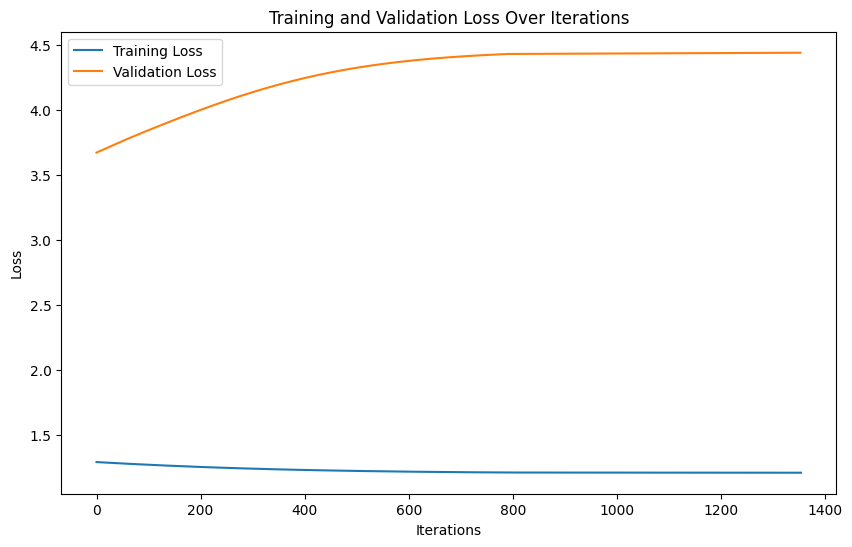

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.show()

In [42]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ys_pred_train_tog = likelihood_tog(gpr_tog(tog_train_to))
    ys_pred_val_tog = likelihood_tog(gpr_tog(tog_val_to))
    ys_pred_test_tog = likelihood_tog(gpr_tog(tog_test_to))
    ys_pred_tog = likelihood_tog(gpr_tog(G_tog_to))

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [43]:
# diff_pred_train_tog = ys_pred_train_tog.mean.detach().numpy()

# diff_pred_train_vars_tog = ys_pred_train_tog.variance.detach().numpy()

diff_pred_test_tog = scaler_tog.inverse_transform(ys_pred_test_tog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_test_tog.size,)
diff_pred_train_tog = scaler_tog.inverse_transform(ys_pred_train_tog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_train_tog.size,)
diff_pred_val_tog = scaler_tog.inverse_transform(ys_pred_val_tog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_val_tog.size,)
diff_pred_tog = scaler_tog.inverse_transform(ys_pred_tog.mean.detach().numpy().reshape(-1, 1)).reshape(diff_tog.size,)

y_pred_test_vars_tog = scaler_tog.inverse_transform(ys_pred_test_tog.variance.detach().numpy().reshape(-1, 1)).reshape(diff_test_tog.size,)

#results on train set with only second-order groups
print("MAE on test set:", mean_absolute_error(y_test_tog, df_test_tog['Pred_Fog'].to_numpy()+df_test_tog['Pred_Sog'].to_numpy()))
print("R2 on test set:", r2_score(y_test_tog, df_test_tog['Pred_Fog'].to_numpy()+df_test_tog['Pred_Sog'].to_numpy()))

MAE on test set: 4.21671467309031
R2 on test set: 0.746761509619543


In [44]:
#results on train set with all groups
print("MAE on train set:", mean_absolute_error(y_train_tog, df_train_tog['Pred_Fog'].to_numpy()+df_train_tog['Pred_Sog'].to_numpy()+diff_pred_train_tog))
print("R2 on train set:", r2_score(y_train_tog, df_train_tog['Pred_Fog'].to_numpy()+df_train_tog['Pred_Sog'].to_numpy()+diff_pred_train_tog))

MAE on train set: 0.6903203551401218
R2 on train set: 0.9940127219073442


In [45]:
df_train_tog['Pred_Tog'] = diff_pred_train_tog
df_val_tog['Pred_Tog'] = diff_pred_val_tog
df_test_tog['Pred_Tog'] = diff_pred_test_tog

C:\Users\49332\AppData\Local\Temp\ipykernel_27560\388336103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_tog['Pred_Tog'] = diff_pred_train_tog
C:\Users\49332\AppData\Local\Temp\ipykernel_27560\388336103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_tog['Pred_Tog'] = diff_pred_val_tog
C:\Users\49332\AppData\Local\Temp\ipykernel_27560\388336103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [47]:
tog_mapping_train = df_train_tog.set_index('SMILES')['Pred_Tog'].to_dict()
df_train['Pred_Tog'] = df_train['SMILES'].map(tog_mapping_train)
df_train['Pred_Tog'].fillna(0, inplace=True)

tog_mapping_val = df_val_tog.set_index('SMILES')['Pred_Tog'].to_dict()
df_val['Pred_Tog'] = df_val['SMILES'].map(tog_mapping_val)
df_val['Pred_Tog'].fillna(0, inplace=True)

tog_mapping_test = df_test_tog.set_index('SMILES')['Pred_Tog'].to_dict()
df_test['Pred_Tog'] = df_test['SMILES'].map(tog_mapping_test)
df_test['Pred_Tog'].fillna(0, inplace=True)

In [48]:
df_eva_train = df_train[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 
df_eva_val = df_val[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 
df_eva_test = df_test[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 

final results evaluating

In [49]:
#metrics
y_pred_train = df_train['Pred_Fog'].to_numpy()+df_train['Pred_Sog'].to_numpy()+df_train['Pred_Tog'].to_numpy()
y_pred_val = df_val['Pred_Fog'].to_numpy()+df_val['Pred_Sog'].to_numpy()+df_val['Pred_Tog'].to_numpy()
y_pred_test = df_test['Pred_Fog'].to_numpy()+df_test['Pred_Sog'].to_numpy()+df_test['Pred_Tog'].to_numpy()

In [51]:
y_all = y_pred_fog + diff_pred_sog + diff_pred_tog

print("MAE on test set:", mean_absolute_error(y, y_all))
print("R2 on test set:", r2_score(y, y_all))

MAE on test set: 1.219703660176057
R2 on test set: 0.9806481340066969


In [52]:
print("MAE on train set:", mean_absolute_error(y_train, y_pred_train))
print("R2 on train set:", r2_score(y_train, y_pred_train))

print("MAE on validation set:", mean_absolute_error(y_val, y_pred_val))
print("R2 on validation set:", r2_score(y_val, y_pred_val))

print("MAE on test set:", mean_absolute_error(y_test, y_pred_test))
print("R2 on test set:", r2_score(y_test, y_pred_test))

MAE on train set: 0.7403143858776363
R2 on train set: 0.9948564227330957
MAE on validation set: 2.328403663451132
R2 on validation set: 0.8654102736922173
MAE on test set: 2.522373157296586
R2 on test set: 0.8720123466974365


In [152]:
df_eva_val

,SMILES,Const_Value,Pred_Fog,Pred_Sog,Pred_Tog
24,C=CCSCC=C,653.397500,539.728638,-5.813184,0.000000
3,O=C(O)C1(O)CC(O)C(O)C(O)C1,665.200000,711.709412,-4.315345,0.000000
17,CCCCOC(=O)CCCCCCCCC(=O)OCCCC,768.000000,757.266602,0.000000,0.000000
38,C/C=C\CCCC,545.466667,542.260010,-5.874498,0.000000
8,C1CCOC1,540.197500,551.126526,0.000000,0.000000
78,C=C1CC(=O)O1,614.975000,702.990173,0.000000,0.000000
6,CCC(C)OC(C)CC,559.000000,573.477417,0.000000,0.000000
64,CCCSCCC,608.432500,609.928711,0.000000,0.000000
36,CCCC(=O)OCC(C)CC,620.000000,615.753723,0.000000,0.000000
89,COC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,468.450000,481.611664,0.000000,0.000000


In [202]:
diff_val_sog

array([ 0.24379914, -0.24996548, -0.54731853,  0.08989758])

In [187]:
y_pred_val

array([1.71222341, 0.80080813, 1.11664999, 1.57456662, 1.03411163,
       1.53935862, 1.66170681, 1.31898089, 1.02927084, 0.90187532,
       0.90373939])

In [196]:
y_test

array([1.2 , 0.76, 1.05, 0.96, 7.3 , 1.8 , 1.9 , 2.6 , 1.4 , 2.6 , 2.  ,
       4.67])

In [198]:
y_pred_test

array([1.09709561, 0.99048859, 1.26678088, 1.12837668, 6.71820545,
       1.42863536, 2.52428222, 2.37780666, 1.34896529, 2.83975792,
       2.10784054, 3.57170987])

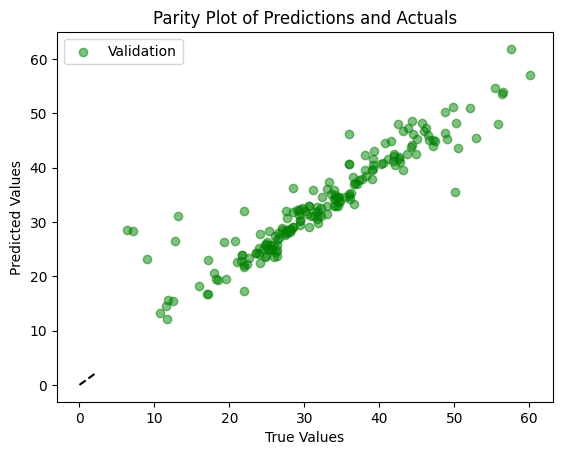

In [53]:
plt.scatter(y_val, y_pred_val, color='green', alpha=0.5, label='Validation')

plt.plot([0, 2], [0, 2], color='black', linestyle='--')

plt.legend()

plt.title('Parity Plot of Predictions and Actuals')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


plt.show()

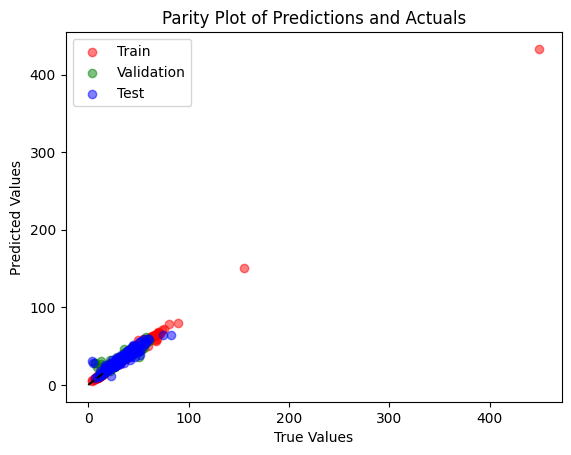

In [54]:
plt.scatter(y_train, y_pred_train, color='red', alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='green', alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Test')

plt.plot([0, 15], [0, 15], color='black', linestyle='--')

plt.legend()

plt.title('Parity Plot of Predictions and Actuals')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


plt.show()

ends here